In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from env import username, password, get_db_url

from sklearn.model_selection import train_test_split

# Exercises

## 1. Acquire data from the cloud database.  

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available.  You will end up using all the tables in the database.  

**Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.** 
- Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) 
- Only include properties that have a latitude and longitude value.

In [2]:
# def new_zillow_data():
#     """
#     This function will:
#     - create a connect_url to mySQL
#     - return a df of the given query from the zillow db
#     """
#     url = get_db_url('zillow')
#     SQL_query = '''
#                 select *,
#                     CAST(latitude / 1e6 AS DECIMAL(10, 6)) AS latitude_dd,
#                     CAST(longitude / 1e6 AS DECIMAL(10, 6)) AS longitude_dd
#                 from properties_2017
#                 join predictions_2017 using (parcelid)
#                 join propertylandusetype using (propertylandusetypeid)
#                 left join architecturalstyletype using (architecturalstyletypeid)
#                 left join airconditioningtype using (airconditioningtypeid)
#                 left join buildingclasstype using (buildingclasstypeid)
#                 left join heatingorsystemtype using (heatingorsystemtypeid)
#                 left join storytype using (storytypeid)
#                 left join typeconstructiontype using (typeconstructiontypeid)
#                 left join unique_properties using (parcelid)
#                 where transactiondate Like '2017%%'
#                 '''
#     return pd.read_sql(SQL_query, url)

In [2]:
def new_zillow_data():
    '''
    This function will:
    - create a connect_url to mySQL
    - return a df of the given query from the zillow db
    '''
    url = get_db_url('zillow')
    SQL_query = '''
        select properties_2017.*,
		predictions_2017.logerror,
        predictions_2017.transactiondate,
		propertylandusetype.propertylandusedesc,
		architecturalstyletype.architecturalstyledesc,
		airconditioningtype.airconditioningdesc,
		buildingclasstype.buildingclassdesc,
		heatingorsystemtype.heatingorsystemdesc,
        storytype.storydesc,
        typeconstructiontype.typeconstructiondesc,
		CAST(latitude / 1e6 AS DECIMAL(10, 6)) AS latitude_dd,
		CAST(longitude / 1e6 AS DECIMAL(10, 6)) AS longitude_dd
from properties_2017
join (
	select parcelid, max(transactiondate) as max_date
    from predictions_2017
    group by parcelid
    ) as pred using (parcelid)
join predictions_2017 on properties_2017.parcelid = predictions_2017.parcelid
		and pred.max_date = predictions_2017.transactiondate
left join propertylandusetype using (propertylandusetypeid)
left join architecturalstyletype using (architecturalstyletypeid)
left join airconditioningtype using (airconditioningtypeid)
left join buildingclasstype using (buildingclasstypeid)
left join heatingorsystemtype using (heatingorsystemtypeid)
left join storytype using (storytypeid)
left join typeconstructiontype using (typeconstructiontypeid)
WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate like '2017%%'
            AND longitude IS NOT NULL
            AND latitude IS NOT NULL	
;
        '''
    return pd.read_sql(SQL_query, url)

In [3]:
def get_zillow_data(filename="zillow.csv"):
    """
    This function will:
    - Check local directory for csv file
        - return if exists
    - If csv doesn't exists:
        - create a df of the SQL_query
        - write df to csv
    - Output zillow df
    """
    if os.path.exists(filename):
        df = pd.read_csv(filename, index_col=0) 
        print('Found and loading CSV!')
        return df
    
    else:
        df = new_zillow_data()
        
        #want to save to csv
        df.to_csv(filename)
        print('Creating new CSV!')
        return df

In [4]:
df = get_zillow_data()

Creating new CSV!


In [5]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,transactiondate,propertylandusedesc,architecturalstyledesc,airconditioningdesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc,latitude_dd,longitude_dd
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,None,NaN,3.5,...,2017-01-01,Single Family Residential,None,None,None,None,None,None,33.634931,-117.869207
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,None,NaN,1.0,...,2017-01-01,Single Family Residential,None,None,None,None,None,None,34.449266,-119.281531
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,None,NaN,2.0,...,2017-01-01,Single Family Residential,None,None,None,None,None,None,33.886168,-117.823170
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,None,8.0,3.0,...,2017-01-01,Single Family Residential,None,None,None,Central,None,None,34.245180,-118.240722
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,None,9.0,3.0,...,2017-01-01,Single Family Residential,None,Central,None,Central,None,None,34.145202,-118.179824


#### 2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquarefeet  52238 non-null  float64
 13  f

In [7]:
df.shape

(52319, 70)

In [26]:
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       38704
architecturalstyletypeid    52249
basementsqft                52272
                            ...  
heatingorsystemdesc         18470
storydesc                   52272
typeconstructiondesc        52243
latitude_dd                     0
longitude_dd                    0
Length: 70, dtype: int64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,52319.0,1.496888e+06,8.594310e+05,3.490000e+02,7.575810e+05,1.500095e+06,2.241248e+06,2.982270e+06
parcelid,52319.0,1.299682e+07,3.350951e+06,1.071186e+07,1.151017e+07,1.257825e+07,1.413036e+07,1.676878e+08
airconditioningtypeid,13615.0,2.439589e+00,3.847925e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,70.0,7.100000e+00,2.665670e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathroomcnt,52319.0,2.300015e+00,1.022816e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,52319.0,3.300770e+00,9.475632e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
buildingqualitytypeid,33654.0,6.264961e+00,1.716328e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,52184.0,2.305276e+00,1.018076e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,389.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [16]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # get a list of the column names that are objects (from the mask)
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    return object_cols



def get_numeric_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # get a list of the column names that are objects (from the mask)
    num_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    
    return num_cols

In [12]:
def nulls_by_col(df):
    """
    This function will:
        - take in a dataframe
        - assign a variable to a Series of total row nulls for ea/column
        - assign a variable to find the percent of rows w/nulls
        - output a df of the two variables.
    """
    num_missing = df.isnull().sum()
    pct_miss = (num_missing / df.shape[0]) * 100
    cols_missing = pd.DataFrame({
                    'num_rows_missing': num_missing,
                    'percent_rows_missing': pct_miss
                    })
    
    return  cols_missing

In [13]:
def nulls_by_row(df, index_id = 'parcelid'):
    """
    """
    num_missing = df.isnull().sum(axis=1)
    pct_miss = (num_missing / df.shape[1]) * 100
    
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': pct_miss})

    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True).reset_index()[[index_id, 'num_cols_missing', 'percent_cols_missing']]
    
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [27]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    # distribution of numerical attributes
    '''
    print(f"""SUMMARY REPORT
=====================================================
          
          
Dataframe head: 
{df.head(3)}
          
=====================================================
          
          
Dataframe info: """)
    df.info()

    print(f"""=====================================================
          
          
Dataframe Description: 
{df.describe().T}
          
=====================================================


nulls in dataframe by column: 
{nulls_by_col(df)}
=====================================================


nulls in dataframe by row: 
{nulls_by_row(df)}
=====================================================
    
    
DataFrame value counts: 
 """)         
    for col in (get_object_cols(df)): 
        print(f"""******** {col.upper()} - Value Counts:
{df[col].value_counts()}
    _______________________________________""")                   
        
    num_cols = len(get_numeric_cols(df))
    num_rows, num_cols_subplot = divmod(num_cols, 3)
    if num_cols_subplot > 0:
        num_rows += 1
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    
    for i, col in enumerate(get_numeric_cols(df)):
        row_idx, col_idx = divmod(i, 3)
        sns.histplot(df[col], ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'Histogram of {col}')
    
    plt.tight_layout()
    plt.show()

SUMMARY REPORT
          
          
Dataframe head: 
        id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0  1727539  14297519                    NaN                       NaN   
1  1387261  17052889                    NaN                       NaN   
2    11677  14186244                    NaN                       NaN   

   basementsqft  bathroomcnt  bedroomcnt buildingclasstypeid  \
0           NaN          3.5         4.0                None   
1           NaN          1.0         2.0                None   
2           NaN          2.0         3.0                None   

   buildingqualitytypeid  calculatedbathnbr  ...  transactiondate  \
0                    NaN                3.5  ...       2017-01-01   
1                    NaN                1.0  ...       2017-01-01   
2                    NaN                2.0  ...       2017-01-01   

         propertylandusedesc  architecturalstyledesc  airconditioningdesc  \
0  Single Family Residential              

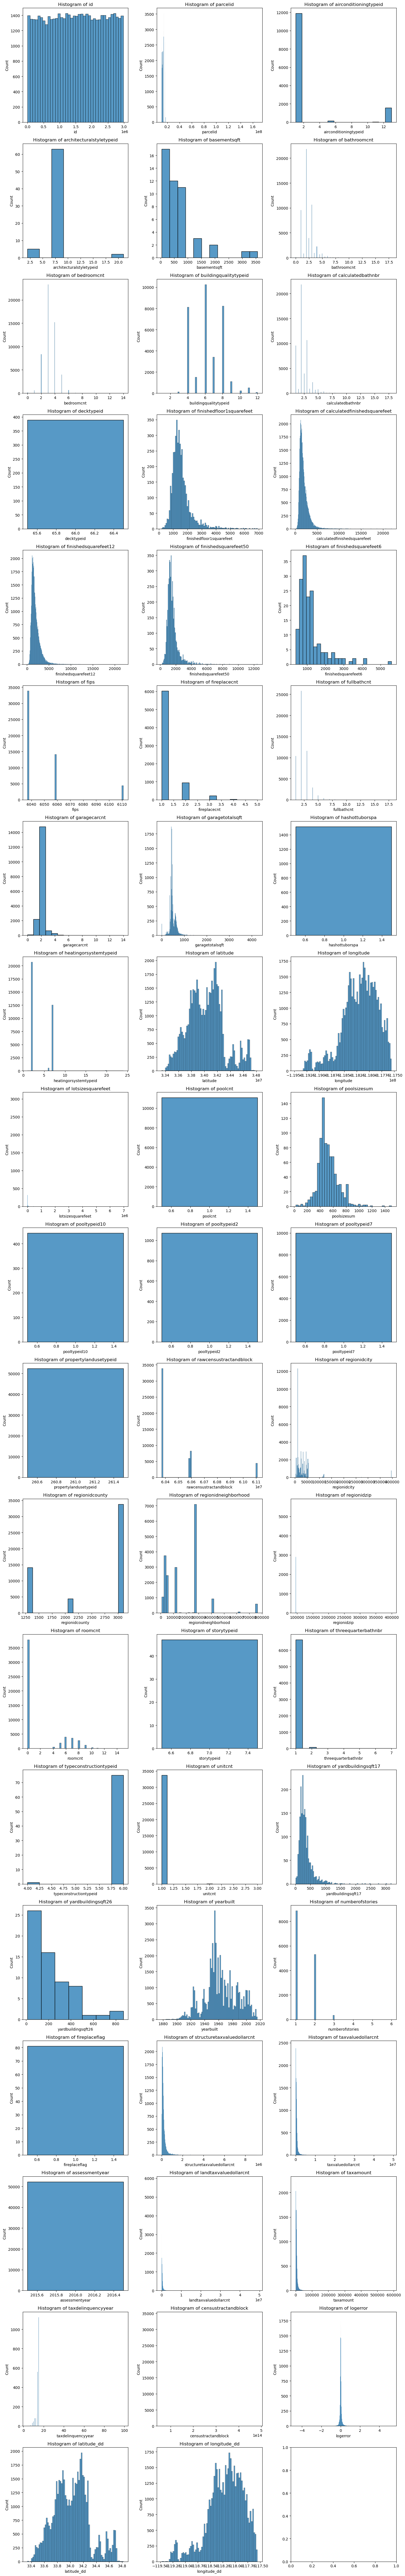

In [28]:
summarize(df)

In [29]:
for col in get_object_cols(df):
    print(f"""*********** Column - {col}: 
{df[col].value_counts()}

______________________________________
""")

*********** Column - buildingclasstypeid: 
Series([], Name: buildingclasstypeid, dtype: int64)

______________________________________

*********** Column - finishedsquarefeet13: 
Series([], Name: finishedsquarefeet13, dtype: int64)

______________________________________

*********** Column - finishedsquarefeet15: 
Series([], Name: finishedsquarefeet15, dtype: int64)

______________________________________

*********** Column - propertycountylandusecode: 
0100    26713
122     13045
0101     6399
1111     3353
1        1066
1110     1024
0104      367
010G       93
0103       91
0108       57
010M       52
0109       18
1112        8
0110        6
0113        6
0141        4
0102        3
0105        3
010V        2
0111        2
0130        2
0131        1
0133        1
0115        1
010L        1
0114        1
Name: propertycountylandusecode, dtype: int64

______________________________________

*********** Column - propertyzoningdesc: 
LAR1          6480
LARS          1380
LBR1N   

#### 3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [30]:
def nulls_by_col(df):
    """
    This function will:
        - take in a dataframe
        - assign a variable to a Series of total row nulls for ea/column
        - assign a variable to find the percent of rows w/nulls
        - output a df of the two variables.
    """
    num_missing = df.isnull().sum()
    pct_miss = (num_missing / df.shape[0]) * 100
    cols_missing = pd.DataFrame({
                    'num_rows_missing': num_missing,
                    'percent_rows_missing': pct_miss
                    })
    
    return  cols_missing

In [31]:
nulls_by_col(df)

,num_rows_missing,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,38704,73.976949
architecturalstyletypeid,52249,99.866205
basementsqft,52272,99.910166
...,...,...
heatingorsystemdesc,18470,35.302663
storydesc,52272,99.910166
typeconstructiondesc,52243,99.854737
latitude_dd,0,0.000000


In [32]:
def nulls_by_row(df, index_id = 'parcelid'):
    """
    """
    num_missing = df.isnull().sum(axis=1)
    pct_miss = (num_missing / df.shape[1]) * 100
    
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': pct_miss})

    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True).reset_index()[[index_id, 'num_cols_missing', 'percent_cols_missing']]
    
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [33]:
nulls_by_row(df)

,parcelid,num_cols_missing,percent_cols_missing
28006,167687839,48,68.571429
8954,167686999,48,68.571429
41347,17188862,47,67.142857
13356,14460039,46,65.714286
21989,14325627,45,64.285714
...,...,...,...
44684,14128839,24,34.285714
83,14172985,24,34.285714
37444,14193288,24,34.285714
39391,14215623,23,32.857143


## Takeaways:
I will consider dropping some columns based on the amount of nulls missing.

# Prepare

#### 1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). 
- There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.

In [35]:
df.propertylandusedesc.value_counts()

Single Family Residential    52319
Name: propertylandusedesc, dtype: int64

#### Takeaway:
Accomplished this in my SQL query

#### 2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [36]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_rows=0.75):
    """
    This function will:
    - take in: 
        - a dataframe
        - column threshold (defaulted to 0.5)
        - row threshold (defaulted to 0.75)
    - calculates the minimum number of non-missing values required for each column/row to be retained
    - drops columns/rows with a high proportion of missing values.
    - returns the new df
    """
    
    column_threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=column_threshold)
    
    row_threshold = int(round(prop_required_rows * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=row_threshold)
    
    return df

In [37]:
new_df = handle_missing_values(df, 0.75, 0.75)
new_df.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,latitude_dd,longitude_dd
0,1727539,14297519,3.5,4.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential,33.634931,-117.869207
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential,34.449266,-119.281531
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential,33.886168,-117.823170
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential,34.245180,-118.240722
4,781532,12095076,3.0,4.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,...,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Single Family Residential,34.145202,-118.179824


In [38]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52317 entries, 0 to 52318
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52317 non-null  int64  
 1   parcelid                      52317 non-null  int64  
 2   bathroomcnt                   52317 non-null  float64
 3   bedroomcnt                    52317 non-null  float64
 4   calculatedbathnbr             52184 non-null  float64
 5   calculatedfinishedsquarefeet  52238 non-null  float64
 6   finishedsquarefeet12          52073 non-null  float64
 7   fips                          52317 non-null  float64
 8   fullbathcnt                   52184 non-null  float64
 9   latitude                      52317 non-null  float64
 10  longitude                     52317 non-null  float64
 11  lotsizesquarefeet             51953 non-null  float64
 12  propertycountylandusecode     52317 non-null  object 
 13  p

In [39]:
# see how many nulls are left
null_new_df = nulls_by_col(new_df)

# look at nulls
null_new_df.sort_values(by='percent_rows_missing', ascending=False)

,num_rows_missing,percent_rows_missing
regionidcity,1034,1.976413
lotsizesquarefeet,364,0.695759
finishedsquarefeet12,244,0.466388
calculatedbathnbr,133,0.254219
fullbathcnt,133,0.254219
censustractandblock,119,0.227460
yearbuilt,112,0.214080
structuretaxvaluedollarcnt,80,0.152914
calculatedfinishedsquarefeet,79,0.151003
regionidzip,24,0.045874


In [40]:
new_df.shape

(52317, 31)

In [25]:
def remove_columns(df, cols_to_remove):
    """
    This function will:
    - take in a df and list of columns
    - drop the listed columns
    - return the new df
    """
    df = df.drop(columns=cols_to_remove)
    return df

In [26]:
def data_prep(df, cols_to_remove=[], prop_required_columns=0.5, prop_required_rows=0.75):
    """
    This function will:
    - take in: 
        - a dataframe
        - list of columns
        - column threshold (defaulted to 0.5)
        - row threshold (defaulted to 0.75)
    - removes unwanted columns
    - remove rows and columns that contain a high proportion of missing values
    - returns cleaned df
    """
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_columns, prop_required_rows)
    return df

In [29]:
clean_df.shape

(52256, 30)

In [33]:
clean_df.shape

(50560, 30)

## Outliers

In [ ]:
def get_upper_outliers(s, m=1.5):
    '''
    Given a series and a cutoff value, m, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + (m * iqr)
    
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [ ]:
def add_upper_outlier_columns(df, m=1.5):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    for col in df.select_dtypes('number'):
        df[col + '_outliers_upper'] = get_upper_outliers(df[col], m)
    return df

In [ ]:
df = add_upper_outlier_columns(df)

In [ ]:
df.head()

In [ ]:
outlier_cols = [col for col in df.columns if col.endswith('_outliers_upper')]

for col in outlier_cols:
    subset = df[col][df[col] > 0]
    print(f"""{col} : 
Number of Observations Above Upper Bound: {subset.count()}
          
{subset.describe()}
------
         """)

In [ ]:
def outlier(df, feature, m=1.5):
    '''
    outlier will take in a dataframe's feature:
    - calculate it's 1st & 3rd quartiles,
    - use their difference to calculate the IQR
    - then apply to calculate upper and lower bounds
    - using the `m` multiplier
    '''
    q1 = df[feature].quantile(.25)
    q3 = df[feature].quantile(.75)
    
    iqr = q3 - q1
    
    upper_bound = q3 + (m * iqr)
    lower_bound = q1 - (m * iqr)
    
    return upper_bound, lower_bound

In [ ]:
# need to update these names
annincUP, annincLOW = outlier(df, 'annual_income')

In [ ]:
# need to update names
annincUP, annincLOW 